In [14]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics
from keras.datasets import mnist
import numpy as np
import pandas as pd
from numpy import float32
np.random.seed(10)

In [17]:
train = pd.read_csv('C:/Users/admin-karim/Downloads/TCGA_train.csv', dtype=float32, delimiter=',')
test = pd.read_csv('C:/Users/admin-karim/Downloads/TCGA_test.csv', dtype=float32, delimiter=',')

In [18]:
train.shape

(599, 20532)

In [19]:
X1 = train.iloc[0:20531]
y1 = train.iloc[:,-1]

In [20]:
X2 = test.iloc[0:20531]
y2 = test.iloc[:,-1]

In [21]:
x = np.concatenate((X1,X2)) 
y = np.concatenate((y1,y2)) 

In [22]:
n_clusters = len(np.unique(y))
print(n_clusters)
x.shape

5


(799, 20532)

## Base line K-Means clustering accuracy

In [23]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

In [24]:
metrics.acc(y, y_pred_kmeans)

c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.9924906132665833

In [45]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


## Defining hyperparameters

In [49]:
dims = [20532, 64, 128, 256, 5]
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=0.01, momentum=0.9)
pretrain_epochs = 100
batch_size = 256
save_dir = 'results/'

In [47]:
autoencoder, encoder = autoencoder(dims, init=init)

## Pretrain auto-encoder

In [50]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/100
799/799 [==============================] - 1s 1ms/step - loss: 57.8638
Epoch 2/100
799/799 [==============================] - 1s 972us/step - loss: 57.8393
Epoch 3/100
799/799 [==============================] - 1s 969us/step - loss: 57.7859
Epoch 4/100
799/799 [==============================] - 1s 942us/step - loss: 57.6916
Epoch 5/100
799/799 [==============================] - 1s 935us/step - loss: 57.5317
Epoch 6/100
799/799 [==============================] - 1s 932us/step - loss: 57.2653
Epoch 7/100
799/799 [==============================] - 1s 935us/step - loss: 56.8257
Epoch 8/100
799/799 [==============================] - 1s 932us/step - loss: 56.1047
Epoch 9/100
799/799 [==============================] - 1s 966us/step - loss: 54.9359
Epoch 10/100
799/799 [==============================] - 1s 934us/step - loss: 53.0804
Epoch 11/100
799/799 [==============================] - 1s 946us/step - loss: 51.1417
Epoch 12/100
799/799 [==============================] - 1s 955us/

799/799 [==============================] - 1s 942us/step - loss: 1.7618
Epoch 98/100
799/799 [==============================] - 1s 927us/step - loss: 1.7620
Epoch 99/100
799/799 [==============================] - 1s 929us/step - loss: 1.7618
Epoch 100/100
799/799 [==============================] - 1s 946us/step - loss: 1.7618


In [51]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Load the pre-trained auto encoder weights

In [52]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Build clustering model

### ClusteringLayer

In [53]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [54]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

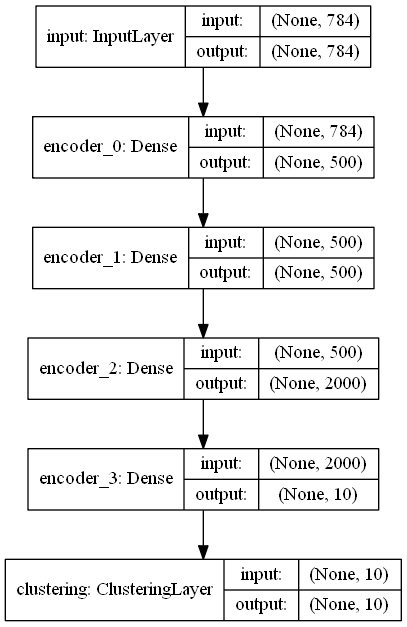

In [17]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


In [55]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Step 1: initialize cluster centers using k-means

In [56]:
kmeans = KMeans(n_clusters=n_clusters, n_init=3)
y_pred = kmeans.fit_predict(encoder.predict(x))

c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


In [57]:
y_pred_last = np.copy(y_pred)

In [58]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [59]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [60]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [61]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [62]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 0: acc = 0.37547, nmi = -1.12500, ari = 0.00000  ; loss= 0
Iter 140: acc = 0.37547, nmi = -1.12500, ari = 0.00000  ; loss= 0.0
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


### Load the clustering model trained weights

In [63]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### Final Evaluation

In [81]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.37807, nmi = 0.31678, ari = 0.22979  ; loss= 0.1373


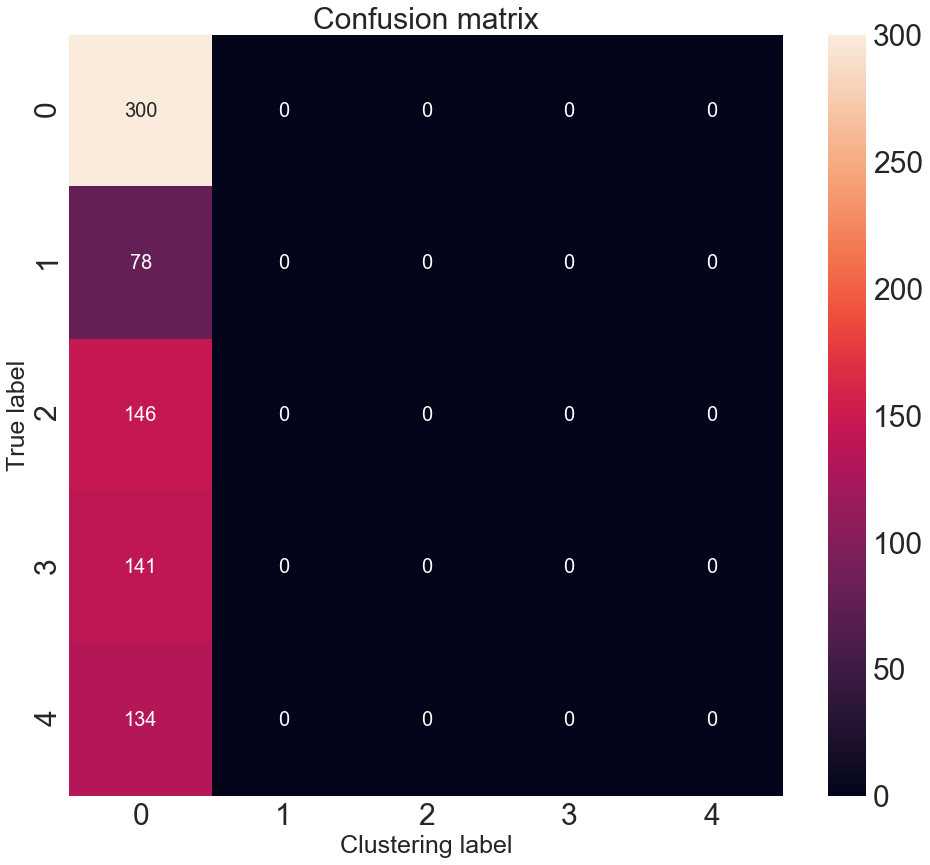

In [64]:
import seaborn as sns
import matplotlib 
%matplotlib inline

import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

### Break down Accuracy metric

linear assignment- [Munkres' Assignment Algorithm](http://csclab.murraystate.edu/~bob.pilgrim/445/munkres.html)

In [65]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.37546933667083854

In [66]:
w

array([[300,  78, 146, 141, 134],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=int64)

In [67]:
ind

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4]])

In [68]:
w.argmax(1)

array([0, 0, 0, 0, 0], dtype=int64)

In [69]:
def vis_data(x_train_encoded, y_train, vis_dim, n_predict, n_train, build_anim):
    cmap = plt.get_cmap('rainbow', 10)

    # 3-dim vis: show one view, then compile animated .gif of many angled views
    if vis_dim == 3:
        # Simple static figure
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                c=y_train[:n_predict], cmap=cmap, edgecolor='black')
        fig.colorbar(p, drawedges=True)
        plt.show()

        # Build animation from many static figures
        if build_anim:
            angles = np.linspace(180, 360, 20)
            i = 0
            for angle in angles:
                fig = plt.figure()
                ax = plt.axes(projection='3d')
                ax.view_init(10, angle)
                p = ax.scatter3D(x_train_encoded[:,0], x_train_encoded[:,1], x_train_encoded[:,2], 
                        c=y_train[:n_predict], cmap=cmap, edgecolor='black')
                fig.colorbar(p, drawedges=True)
                outfile = 'anim/3dplot_step_' + chr(i + 97) + '.png'
                plt.savefig(outfile, dpi=96)
                i += 1
            call(['convert', '-delay', '50', 'anim/3dplot*', 'anim/3dplot_anim_' + str(n_train) + '.gif'])

    # 2-dim vis: plot and colorbar.
    elif vis_dim == 2:
        plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], 
                c=y_train[:n_predict], edgecolor='black', cmap=cmap)
        plt.colorbar(drawedges=True)
        plt.show()

In [72]:
# Encode a number of MNIST digits, then perform t-SNE dim-reduction.
x_train_predict = encoder.predict(x)
from sklearn import manifold
%matplotlib inline

#print "Performing t-SNE dimensionality reduction..."
x_train_encoded = manifold.TSNE(n_components=2).fit_transform(x_train_predict)
#np.save('%sx_%sdim_tnse_%s.npy' % (266, 2, 266), x_train_encoded)
#x_train_encoded = np.load(s

ValueError: Invalid RGBA argument: 3.0

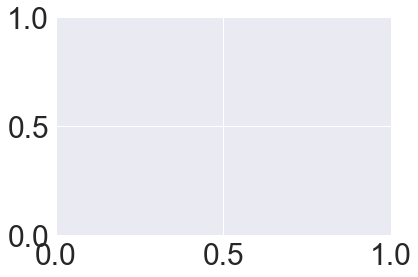

In [73]:
# Visualize result.
train_new = False
n_train = 699
predict_new = False
n_predict = 699
vis_dim = 2
build_anim = False
    
vis_data(x_train_encoded, y, vis_dim, n_predict, n_train, build_anim)